<b> save one week data from 2G </b>

In [ ]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.cluster import KMeans
from pandas import ExcelWriter
from datetime import datetime

fn_2g = "2G.csv"
Main_Input_Network = pd.read_csv(fn_2g)

st = datetime.strptime('2019-02-23 00:00:00', '%Y-%m-%d %H:%M:%S')
ed = datetime.strptime('2019-03-02 00:00:00', '%Y-%m-%d %H:%M:%S')
Main_Input_Network['DateTime'] = pd.to_datetime(Main_Input_Network['DateTime'])
Main_Input_Network = Main_Input_Network[(Main_Input_Network['DateTime'] >= st) & (Main_Input_Network['DateTime'] < ed)]

Main_Input_Network.to_csv('2Gweek.csv', encoding='utf-8', index = False)

<b> save one week data from 3G </b>

In [195]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.cluster import KMeans
from pandas import ExcelWriter
from datetime import datetime

fn_2g = "3G.csv"
Main_Input_Network = pd.read_csv(fn_2g)

st = datetime.strptime('2019-02-23 00:00:00', '%Y-%m-%d %H:%M:%S')
ed = datetime.strptime('2019-03-02 00:00:00', '%Y-%m-%d %H:%M:%S')
Main_Input_Network['DateTime'] = pd.to_datetime(Main_Input_Network['DateTime'])
Main_Input_Network = Main_Input_Network[(Main_Input_Network['DateTime'] >= st) & (Main_Input_Network['DateTime'] < ed)]

Main_Input_Network.to_csv('3Gweek.csv', encoding='utf-8', index = False)

<b> load one week 2G and 3G data </b>

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from sklearn.cluster import KMeans
from pandas import ExcelWriter

Tech = '2G'

if Tech == '2G':
    #fn_2g = "2Gweek.csv"
    Main_Input_Network = pd.read_csv('F:\Output Messenger\Received Files\RawData(01Feb-07Feb)_2G\RawData(01Feb-07Feb)_2G.csv')
elif Tech == '3G':
    #fn_3g = "3Gweek.csv"
    Main_Input_Network = pd.read_csv('F:\Output Messenger\Received Files\RawData(01Feb-07Feb)_3G\RawData(01Feb-07Feb)_3G.csv')

#print(Main_Input_Network.columns)

ModuleNotFoundError: No module named 'scipy'

### KPI Title Mapping

In [2]:
if Tech == '2G': # gsm
    gsm_dict = {'DateTime' : 'Date', 'CellName' : 'Cell', 'BCCH_DownTime_Duration(s)' : 'DT',
           'Availability' : 'AVL', 'TCH_Traffic' : 'TCHTRF'}
    keys = Main_Input_Network.columns
    Main_Input_Network.columns = [gsm_dict[key] for key in keys]
    
elif Tech == '3G': # wcdma
    wcdma_dict = {'DateTime' : 'Date', 'CellName' : 'Cell', 'Voice_Traffic(GB)' : 'TCHTRF',
                 'DownTimeAuto(S)' : 'DTA', 'DownTimeManual(S)' : 'DTM'}
    keys = Main_Input_Network.columns
    Main_Input_Network.columns = [wcdma_dict[key] for key in keys]


<b> calculate availability </b>

In [3]:
if Tech == '3G':    # drop downtime columns - 3G
    Main_Input_Network[Main_Input_Network['DTA']<5]['DTA']=0
    Main_Input_Network[Main_Input_Network['DTM']<5]['DTM']=0
    Main_Input_Network[Main_Input_Network['DTA']>3595]['DTA']=3600
    Main_Input_Network[Main_Input_Network['DTM']>3595]['DTM']=3600

    Main_Input_Network['AVL'] = (3600 - Main_Input_Network['DTA'] - Main_Input_Network['DTM'])/36
    Main_Input_Network[Main_Input_Network['AVL'] < 0 ]['AVL'] = 0

    Main_Input_Network.drop(['DTM','DTA'],axis=1, inplace = True)
    
elif Tech == '2G':  # drop downtime columns - 2G
    Main_Input_Network.drop(['DT'],axis=1, inplace = True)


In [23]:
#Main_Input_Network = Main_Input_gsm.copy()
#Main_Input_Network = Main_Input_wcdma.copy()
#Main_Input_Network = Main_Input_Network.merge(Main_Input_gsm, left_on = ['Cellnm'], right_on = ['Cellnm'])

#Main_Input_Network = pd.concat([Main_Input_Network, Main_Input_gsm], axis = 0, sort=False)


<b> clean sector name </b>

In [4]:
import re
pat = '[A-Z]{2}[1-9]*[GLU]*[0-9]{4}[A-F]{1}'
out_temp = Main_Input_Network['Cell'].apply(lambda x:  ''.join(re.findall(pat, x)))
pat = '[1-9]{1}[GLU]{1}'
Main_Input_Network['Cell'] = out_temp.apply(lambda x: re.sub(pat,'',x))
#Main_Input_Network[Main_Input_Network.Cell2.str.len()==0]
Main_Input_Network = Main_Input_Network[Main_Input_Network.Cell.str.len()==7]

<b>count number of carriers</b>

In [5]:
cell_carrier = pd.DataFrame(columns = ['Cellnm','Carrier'])
cell_carrier['Carrier'] = Main_Input_Network.Cell.str[-1] 
cell_carrier['Cellnm'] = Main_Input_Network.Cell.str[:-1]
#cell_carrier['Tech'] = Main_Input_Network['Tech']
cell_carrier = cell_carrier.drop_duplicates(['Cellnm', 'Carrier']).reset_index(drop = True)
cell_carrier = cell_carrier.groupby(['Cellnm'],as_index = False).count()
Main_Input_Network['Cellnm'] = Main_Input_Network['Cell']
Main_Input_Network['Cellnm'] = Main_Input_Network.Cell.str[:-1]
Main_Input_Network = Main_Input_Network.merge(cell_carrier, left_on = ['Cellnm'], right_on = ['Cellnm'])

<b> create conditions for aggregation</b>

In [ ]:
cond_a = (Main_Input_Network.Cell.str[-1] == 'A') | \
((Main_Input_Network['Carrier'] > 4) & (Main_Input_Network.Cell.str[-1] == 'D'))
cond_b = (Main_Input_Network.Cell.str[-1] == 'B') | (Main_Input_Network.Cell.str[-1] == 'E')
cond_c = (Main_Input_Network.Cell.str[-1] == 'C') | (Main_Input_Network.Cell.str[-1] == 'F')
cond_d = (Main_Input_Network['Carrier'] <= 4) & (Main_Input_Network.Cell.str[-1] == 'D')

a = np.where(cond_a, 'AD', 
    np.where(cond_b, 'BE',
    np.where(cond_c, 'CF',
    np.where(cond_d, 'D','None'))))
Main_Input_Network['Cond'] = a
#np.where(m1, 'Has Family', 'No Family')

<b>merge traffic and availability</b>

In [28]:
#df_grpd = pd.DataFrame(columns = ['Cellnm','TCHTRF','AVL'])
df_grpd = Main_Input_Network.groupby(['Cond','Date','Cellnm'],as_index = False)['TCHTRF'].sum()
df_grpd_avl = Main_Input_Network.groupby(['Cond','Date','Cellnm'],as_index = False)['AVL'].mean()
df_grpd = df_grpd.merge(df_grpd_avl, left_on = ['Cond','Date','Cellnm'], right_on = ['Cond','Date','Cellnm'])

In [29]:
df_grpd['Cell'] = df_grpd['Cellnm']+df_grpd.Cond.str[0]

In [30]:
#ff = df_grpd[df_grpd.Cell.str[:2] == 'GL']
df_grpd.to_csv('agg_'+ Tech +'.csv', encoding='utf-8', index = False)

### load 2g and 3g aggrigated data

In [1]:
import pandas as pd
import numpy as np

fn_2g = "agg_2G.csv"
Main_Input_gsm = pd.read_csv(fn_2g)

fn_3g = "agg_3G.csv"
Main_Input_Network = pd.read_csv(fn_3g)

Main_Input_gsm['Gen'] = '2G'
Main_Input_Network['Gen'] = '3G'


In [2]:

Main_Input_Network = Main_Input_Network[['Date','TCHTRF','AVL','Cell','Gen']].merge(Main_Input_gsm[['Date','TCHTRF','AVL','Cell','Gen']], 
                                                                              left_on = ['Date','Cell'], right_on = ['Date','Cell'], how = 'outer')
#Main_Input_Network.head()

In [3]:
#Main_Input_Network['Gen_x'].fillna('')
Main_Input_Network['TCHTRF'] = 0
Main_Input_Network['Gen'] = ''
Main_Input_Network[['Gen_x','Gen_y']] = Main_Input_Network[['Gen_x','Gen_y']].replace(np.nan, '', regex=True)

Main_Input_Network['Gen'] = Main_Input_Network['Gen_y'] + Main_Input_Network['Gen_x']

Main_Input_Network[['AVL_x','AVL_y','TCHTRF_x','TCHTRF_y']] = \
Main_Input_Network[['AVL_x','AVL_y','TCHTRF_x','TCHTRF_y']].replace(np.nan, 0, regex=True)

Main_Input_Network['TCHTRF'] = Main_Input_Network['TCHTRF_x'] + Main_Input_Network['TCHTRF_y']

In [4]:
Main_Input_Network.drop(['TCHTRF_x','TCHTRF_y','Gen_x','Gen_y'],axis=1, inplace = True)

### Write excel

In [7]:
'''
writer = ExcelWriter('Aggregated.xlsx')
data_merged_df.to_excel(writer)
writer.save()
'''

### Weekly Traffic

In [ ]:
'''
weekly_payload = pd.DataFrame(columns = ['Weekly_Payload','Sample'])
weekly_payload['Weekly_Payload'] = data_merged_df.groupby('Sector')['DL_Payload'].sum()
weekly_payload['Sample'] = data_merged_df.groupby('Sector').count()
'''

### Replace miss data with the average

In [5]:
# Filter
Main_Input_Network = Main_Input_Network.rename(columns={'Cell': 'Sector'})

# old style: Main_Input_Network = Main_Input_Network[(Main_Input_Network['AVL_x']>95) | (Main_Input_Network['AVL_y']>95)]
Main_Input_Network = Main_Input_Network[(Main_Input_Network['AVL_x'] + Main_Input_Network['AVL_y'])/2 > 95]

print(len(Main_Input_Network)/168)
grouped = Main_Input_Network.groupby('Sector')#.count()#.reset_index()
Main_Input_Network = grouped.filter(lambda x: x['Sector'].count() > 158).reset_index(drop = True)
print(len(Main_Input_Network)/168)
yy = Main_Input_Network.Date.unique()
xx = Main_Input_Network.Sector.unique()
z = [(x, y) for x in xx for y in yy]
zz = pd.DataFrame(z)
zz.columns = ['Sector','Date']

Main_Input_Network = Main_Input_Network.merge(zz, left_on= ['Sector','Date'], right_on= ['Sector','Date'], how = 'right')
Main_Input_Network['Prov'] = Main_Input_Network.Sector.str.slice(0,2)
Main_Input_Network.sort_values(['Sector', 'Date'], ascending=[True, True], inplace = True)
Main_Input_Network = Main_Input_Network.reset_index(drop = True)
Main_Input_Network = Main_Input_Network.fillna(method='ffill')

40785.28571428572
39768.14880952381


### Select complete data - no missing

In [6]:
df1 = Main_Input_Network[Main_Input_Network.Date.groupby(Main_Input_Network.Sector).transform('count') % 168 == 0]
#print(df1)
#df1 = df1.drop(['Sector','Date'],axis = 1)
#print(df1.dtypes)
X = df1['TCHTRF'].values

<b> detect extermums - three points algorithm </b>

In [7]:
def extract3points(c):
    #--  proposed algorithm --
    # 1. run pick finder
    pick_pos, trough_pos, ara = findPeaks(c)

    trough_pos = np.array(trough_pos)
    pick_pos = np.array(pick_pos)

    through_0 = trough_pos[(trough_pos>=13) & (trough_pos<=17)]
    
    if through_0.size == 0:
        through_0 = np.mean(ara[13:17])
    elif through_0.shape[0] > 1:
        #print(through_0[np.argmax(ara[through_0])])
        through_0 = np.max(ara[through_0])
    else:
        #print(through_0)
        through_0 = ara[through_0]

    # 2. select the minimum close to 3pm +/- 2 hours (from index = 13 to 17) 
    # otherwise select the average from 2pm to 4pm (from index 14 to 16)

    # 3. find the pick close to 11am +/- 2 hours (from index = 9 to 13)
    peak_0 = pick_pos[(pick_pos>=9) & (pick_pos<=13)]
    if peak_0.size == 0:
        peak_0 = np.mean(ara[9:13])
    elif peak_0.shape[0] > 1:
        #print(peak_0[np.argmax(ara[peak_0])])
        peak_0 = np.max(ara[peak_0])
    else:
        #print(peak_0)
        peak_0 = ara[peak_0]
    # 4. find the maximum close 7pm +/- 2 hours (from index = 17 to 21)
    # 4.1 find the maximum between 16 to 23
    peak_1 = pick_pos[(pick_pos>=16) & (pick_pos<=23)]
    if peak_1.size == 0:
        peak_1 = np.mean(ara[17:23])
    elif peak_1.shape[0] > 1:
        #print(peak_1[np.argmax(ara[peak_1])])
        peak_1 = np.max(ara[peak_1])
    else:
        #print(peak_1)
        peak_1 = ara[peak_1]

    # 5. calculate the difference between the extremums
    n_feat = 3
    xs = np.zeros(n_feat)
        
    xs[0] = peak_0
    xs[1] = through_0
    xs[2] = peak_1
        
    d = np.zeros(n_feat)
        
    d[0] = peak_0 - through_0
    d[2] = peak_0 - peak_1
    d[1] = peak_1 - through_0
    
        
    '''
    d[0] = peak_0 - through_0
    d[2] = peak_0 - peak_1
    d[1] = peak_1 - through_0
    '''
    
    # 6. compute a binary vector that specifies whether 
    # extremums have been found by the peak detector
    return xs, d, ara

def findPeaks(a):

    aas = np.convolve(a,[1/4,1/2,1/4],'same')
    arad = np.diff(aas)
    arads = np.sign(arad)
    aradsc = np.convolve(arads,[1,-1])
    pos = np.where(aradsc == -2)
    peak_pos = list(pos[0])

    pos = np.where(aradsc == 2)
    trough_pos = list(pos[0])

    return peak_pos, trough_pos, aas


### Clustering

1542
6698
9106
2862
5542
1730
7700
4736


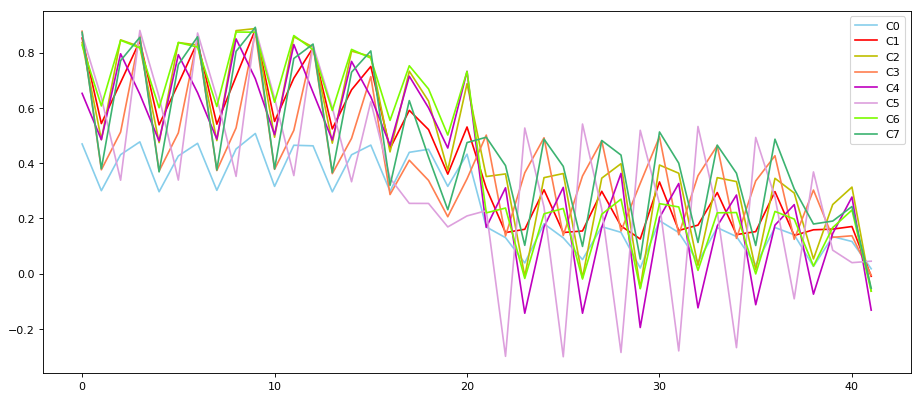

39916
39916


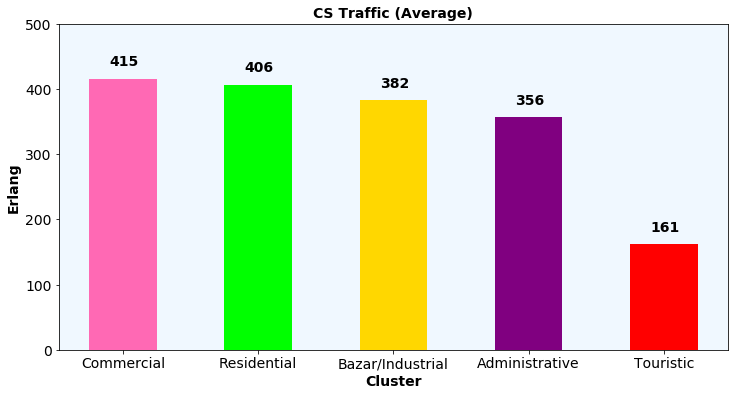

In [12]:
from sklearn.metrics import silhouette_score
import numpy.ma as ma
from pandas import ExcelWriter
from sklearn.cluster import KMeans
import numpy as np
import pylab as plt

sector = df1.groupby('Sector')['Date'].count().index.tolist()
x = X.reshape(round(np.size(X)/168),168)

#x = np.where(np.isnan(x), ma.array(x, mask=np.isnan(x)).mean(axis = 0), x)    
#x = np.where(np.isnan(x), ma.array(x, mask=np.isnan(x)).mean(axis=0)[:, np.newaxis], x)

# all zero rows are deleted
xsum = x.sum(axis=1, keepdims=True)
ind_zero_sum = np.argwhere(xsum == 0)
ind_zero_sum = np.unique(ind_zero_sum[:,0])
sector = [sector[i] for i in range(len(sector)) if i not in ind_zero_sum.tolist() ]
x = np.delete(x, ind_zero_sum, axis=0)

# rows with nan values are deleted
ind_nan = np.argwhere(np.isnan(x))
ind_nan = np.unique(ind_nan[:,0])
x = np.delete(x, ind_nan, axis=0)
sector = [ sector[i] for i in range(len(sector)) if i not in ind_nan.tolist() ]

# rows with low number of connected users or 

#xsum = x.sum(axis = 1, keepdims = True)
#ind_zero_sum = np.argwhere(xsum < 30)
#ind_zero_sum = np.unique(ind_zero_sum[:,0])

#print(len(ind_zero_sum))
sector = [sector[i] for i in range(len(sector)) if i not in ind_zero_sum.tolist() ]
x = np.delete(x, ind_zero_sum, axis=0)
xo = x
# normalise
x = x/x.max(axis=1, keepdims=True)
#x = x/x.sum(axis=1, keepdims=True)

# ------>  detect three points <------
nH = 24
nPoints = 3
n_days = round(x.shape[1]/nH)
d = np.full((len(x), 2*n_days*nPoints),0.0)

#xs = np.full((len(x), n_days*nPoints),0.0)

dc = n_days*nPoints

for i in range(len(x)):
        t = list(range(nH))
        for iday in range(n_days):
            d[i,iday*nPoints:(iday+1)*nPoints], d[i,dc+iday*nPoints:dc+(iday+1)*nPoints], ara = \
            extract3points(x[i,iday*nH:(iday+1)*nH])   
    
opt_k = False
if not opt_k:
    nC = 8
    xs = np.zeros(nC)
    xave = np.zeros(nC)
    
    kmeans = KMeans(n_clusters = nC, random_state=0).fit(d)
    kmeans.labels_
    kmeans.cluster_centers_
    #labels = [list(a) for a in zip(Sector, kmeans.labels_.tolist())]
    clr = ['skyblue','r','y','coral','m','plum','lawngreen','mediumseagreen']#,'k','b','g','c']
    plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    for i in range(nC):
        xs[i] = np.sum(xo[kmeans.labels_ == i,:])/1e6
        xave[i] =  xs[i]/np.count_nonzero(kmeans.labels_ == i)*1e3
        if np.count_nonzero(kmeans.labels_ == i)>50:
            plt.plot(kmeans.cluster_centers_[i,:], label='C' + str(i),color = clr[i])
            print(np.count_nonzero(kmeans.labels_ == i))
    plt.legend()
    plt.show()
    
    ## -------   ------      5 clusters
    xave_5clust = np.zeros(5)
    xave_5clust[0] = xave[0]
    xave_5clust[1] = np.sum( xo[ np.isin( kmeans.labels_, [1,7]),:]) / np.count_nonzero(np.isin(kmeans.labels_,[1,7]))/1e3
    xave_5clust[2] = np.sum( xo[ np.isin( kmeans.labels_, [2,4,6]),:]) / np.count_nonzero( np.isin( kmeans.labels_, [2,4,6]))/1e3
    xave_5clust[3] = xave[3]
    xave_5clust[4] = xave[5]
    
    ## -----------------------------------
    #create new df 
    print(len(sector))
    print(len(kmeans.labels_.tolist()))
    df = pd.DataFrame({'Sector':sector, 'Labels': kmeans.labels_.tolist(), 'Total': list(np.sum(xo, axis = 1))})
    writer = ExcelWriter('temp_Labels' + str(nC) + 'ave_avail.xlsx')# '3p_max_8_amp_diff.xlsx')
    df.to_excel(writer, index=False)
    writer.save()
    # sort
    #clr_disp =  ['red','purple','hotpink','skyblue','darkred','yellow','green','lawngreen']
    clr_disp =  ['red','orange','lime','purple','royalblue','gold','green','hotpink']
    #['skyblue','r','y','coral','m','plum','lawngreen','mediumseagreen']
    #clr_lbl = ['red','purple','pink','lightblue','darkred','yellow','green','lightgreen']
    clr_lbl = ['Event','Comm. HOP','Resi. LOP','Admin','Resi. HE',
               'Bazar/IND','Resi. HOP','Comm. LOP']
    ind_sort = np.argsort(xs)
    ind_sort = ind_sort[::-1]
    ind_sort_ave = np.argsort(xave)
    ind_sort_ave = ind_sort_ave[::-1]
    clr_s = [clr_disp[i] for i in ind_sort]
    clr_ave = [clr_disp[i] for i in ind_sort_ave]
    
    cl_s = [clr_lbl[i] for i in ind_sort]
    cl_ave = [clr_lbl[i] for i in ind_sort_ave]
    
    ## 5 clusters
    clr_disp5 = ['red','hotpink','lime','purple','gold']
    clr_lbl5 = ['Touristic','Commercial','Residential','Administrative','Bazar/Industrial']
    ind_sort5 = np.argsort(xave_5clust)
    ind_sort5 = ind_sort5[::-1]
    clr_5 = [clr_disp5[i] for i in ind_sort5]
    cl_5 = [clr_lbl5[i] for i in ind_sort5]
    # plot
    '''
    fig, ax = plt.subplots(2,1)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    plt.subplots_adjust(hspace = 0.4)
    
    ax[0].set_facecolor('aliceblue') 
    ax[0].bar(cl_s, xs[ind_sort], color = clr_s)
    ax[0].set_title('CS Traffic (Sum)')
    ax[0].set_xlabel('Cluster')
    ax[0].set_ylabel(r'$10^{6}$ Erlang')
   
    ax[1].set_facecolor('aliceblue') 
    ax[1].bar(cl_ave,xave[ind_sort_ave], color = clr_ave)
    ax[1].set_title('CS Traffic (Average)')
    ax[1].set_xlabel('Cluster')
    ax[1].set_ylabel(r'$10^{3}$ Erlang')
    '''
    fig, ax = plt.subplots(1,1)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    plt.subplots_adjust(hspace = 0.4)
    ax.set_ylim((0,500))
    ax.set_facecolor('aliceblue') 
    ax.bar(cl_5, xave_5clust[ind_sort5]/7*1e3, color = clr_5, width=0.5)
    ax.set_title('CS Traffic (Average)', fontweight = 'bold', fontsize = 14)
    ax.set_xlabel('Cluster',fontweight = 'bold', fontsize = 14)
    #ax.set_ylabel(r'$10^{3}$ Erlang')
    ax.set_ylabel('Erlang',fontweight = 'bold', fontsize = 14)
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    for i, v in enumerate(xave_5clust[ind_sort5]/7*1e3):
        ax.text( i-0.1, v + 20 , str(int(v)), color = 'black', fontweight='bold', fontsize=14)
else:
    range_n_clusters = [3, 4, 5, 6]

    for nC in range_n_clusters:
   
        kmeans = KMeans(n_clusters = nC, random_state=0).fit(x)
        cluster_labels = kmeans.fit_predict(x)
        silhouette_avg = silhouette_score(x, cluster_labels)
        print('For n_clusters =', nC,
              'The average silhouette_score is :', silhouette_avg)

In [11]:
xave_5clust[ind_sort5]/7*1e3

array([415.51348623, 406.61913719, 382.29534261, 356.49750085,
       161.94515685])

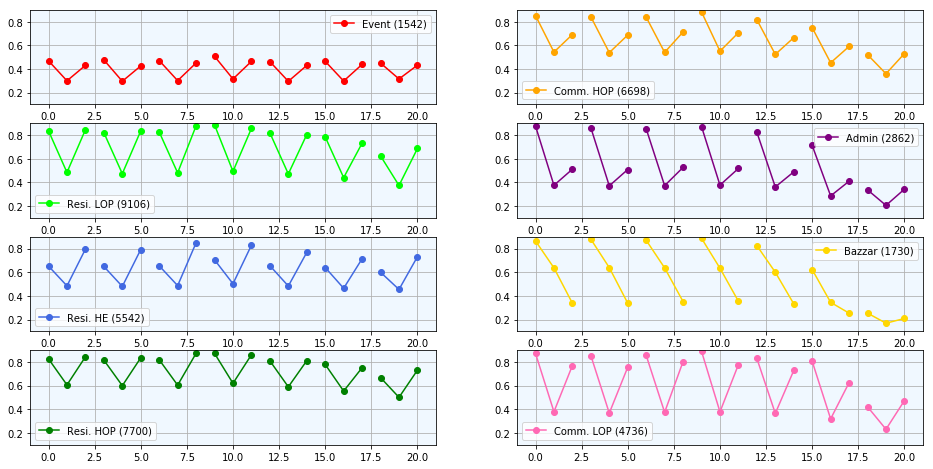

In [11]:
#plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots(4, 2)
fig.set_figheight(8)
fig.set_figwidth(16)

cc = 0
#clr = ['lawngreen','coral','plum','skyblue','y','m','mediumseagreen','red']
clr =  ['red','orange','lime','purple','royalblue','gold','green','hotpink']#,'gold','b','indianred','c']
clr_lbl = ['Event','Comm. HOP','Resi. LOP','Admin','Resi. HE',
               'Bazzar','Resi. HOP','Comm. LOP']
for row in ax:
    for col in row:
        for i in range(7):
            if i==0:
                # label = 'C' + str(cc) + ' (' + str(np.count_nonzero(kmeans.labels_ == cc)) +')'
                label_val = clr_lbl[cc] + ' (' + str(np.count_nonzero(kmeans.labels_ == cc)) +')'
                col.set_facecolor('aliceblue')
                col.plot(range(i*3,(i+1)*3),kmeans.cluster_centers_[cc,i*3:(i+1)*3], \
                         label = label_val, color = clr[cc], marker='o')
                
            else:
                col.plot(range(i*3,(i+1)*3),kmeans.cluster_centers_[cc,i*3:(i+1)*3], color = clr[cc], marker='o')
        col.plot([])
        #col.set_ylim((0.1,0.9)), col.set_xlim((0,20))
        col.set_ylim((0.1,0.9)), col.set_xlim((-1,21))
        col.legend()
        col.grid()
        cc += 1

plt.show()

### plot

IndexError: list index out of range

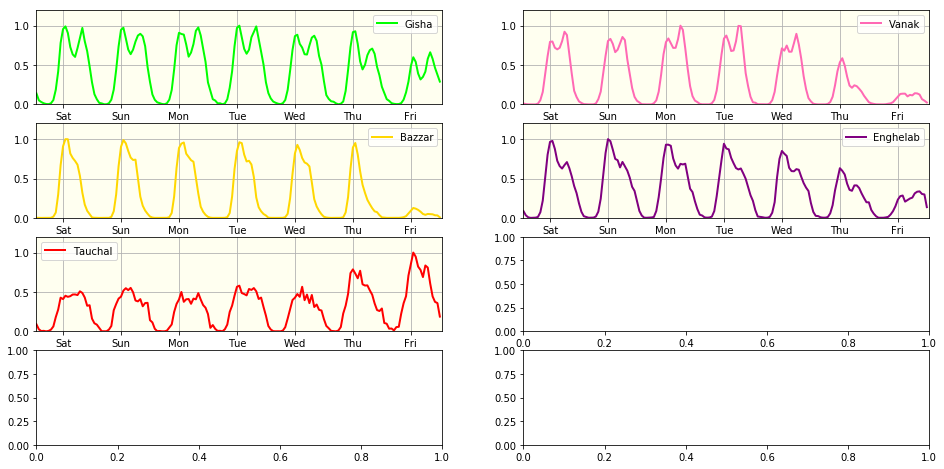

In [16]:
'''
clr = ['lawngreen','coral','plum','skyblue','y','m','mediumseagreen','red']
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
inda = np.where(np.array(sector) =='TH0423C')[0][0]#TH0326A #AG0026B
indb = np.where(np.array(sector) =='TH1560C')[0][0]
indc = np.where(np.array(sector) =='TH0264C')[0][0]#TH0326A #AG0026B
indd = np.where(np.array(sector) =='TH1584D')[0][0]

plt.plot(x[inda,:], label='Enghelab', color = 'plum')
plt.plot(x[indb,:], label='Pirozi', color = 'skyblue')
plt.plot(x[indc,:], label='Bazar', color = 'y')
plt.plot(x[indd,:], label='TH1584D', color = 'r')
#plt.plot(xo[1002,:], label='original')
plt.legend()
'''
fig, ax = plt.subplots(4, 2)
fig.set_figheight(8)
fig.set_figwidth(16)

#cell_list = ['TH2358B','TH1713A','TH0675D','TH0423C','TH1905A','TH1912C','TH1299B', 'KJ0673C']# 'TH2358B'
cell_list = ['TH0675D','TH1857A','TH1912C','TH0423C','TH0544B']
## same color cell_list = ['YZ0137A','TH1713A','TH0675D','TH0423C','TH1905A','TH1912C','TH1299B', 'KJ0673C']
cc = 0

clr =  ['red','orange','lime','purple','royalblue','gold','green','hotpink']
clr = ['lime','hotpink','gold','purple','red']
#clr =  ['red','purple','lawngreen','skyblue','darkred','yellow','green','hotpink']
#lbl = ['Enghelab','Iranfair','Bazar','Mosala','Kurdistan-Attar','KJ-Beheshti','Gisha','Narmak']
lbl = ['Iranfair', 'Kurdistan-Attar', 'Gisha', 'Enghelab','Piroozi', 'Bazzar', 'Narmak', 'KJ-Beheshti']
lbl = ['Gisha','Vanak','Bazzar','Enghelab','Tauchal']
for row in ax:
    for col in row:
        ind = np.where(np.array(sector) ==cell_list[cc])[0][0]
        col.set_facecolor('ivory')
        col.plot(x[ind,:], label=lbl[cc], linewidth=2, color =  clr[cc])
        #col.plot(x[ind,:], label=lbl[cc], linewidth=2, color = [0.3, 0.3, 0.3])#color = clr[cc])
        #col.set_ylim((0.1,0.9)), col.set_xlim((0,20))
        col.set_ylim((0.0,1.2)), col.set_xlim((0,168))
        col.set_xticks([11, 35, 59, 83, 107, 131, 155])
        col.set_xticklabels(['Sat','Sun','Mon','Tue','Wed','Thu','Fri'])
        col.legend()
        col.grid()
        cc += 1

plt.show()


## HOP HE examples

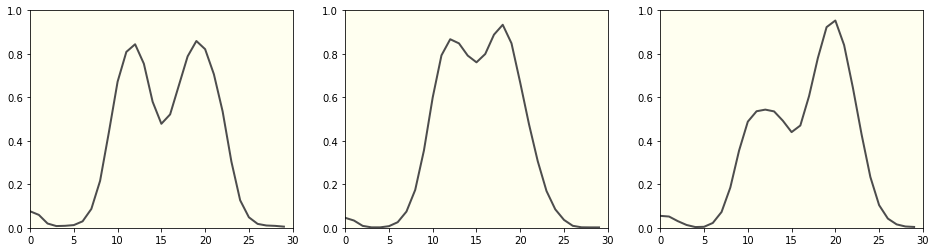

In [25]:
fig, ax = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(16)

#cell_list = ['TH0423C','TH2358B','TH1912C','TH1722B','TH1713A','KJ0673C','TH0675D','TH1330A'] 'TH2358B'
cell_list = ['KJ0270A','TH0430B','TH1421A','QN0088A','TH0241A','TH0033B','TH1299B', 'KJ0673C']
cc = 0
#clr = ['lawngreen','coral','plum','skyblue','y','m','mediumseagreen','red']
#clr = ['purple','red','yellow','darkred','skyblue','hotpink','lawngreen','green']
clr =  ['red','orange','lime','purple','royalblue','gold','green','hotpink']
#clr =  ['red','purple','lawngreen','skyblue','darkred','yellow','green','hotpink']
#lbl = ['Enghelab','Iranfair','Bazar','Mosala','Kurdistan-Attar','KJ-Beheshti','Gisha','Narmak']
lbl = ['Iranfair', 'Kurdistan-Attar', 'Gisha', 'Enghelab','Piroozi', 'Bazzar', 'Narmak', 'KJ-Beheshti']
for col in ax:
    ind = np.where(np.array(sector) ==cell_list[cc])[0][0]
    col.set_facecolor('ivory')
    col.plot(np.convolve(x[ind,:30],[1/4,1/2,1/4],'same'), label=lbl[cc], linewidth=2, color = [0.3, 0.3, 0.3])#color = clr[cc])
    #col.set_ylim((0.1,0.9)), col.set_xlim((0,20))
    col.set_ylim((0.0,1.0)), col.set_xlim((0,30))

    #col.set_xticks([11, 35, 59, 83, 107, 131, 155])
    #col.set_xticklabels(['Sat','Sun','Mon','Tue','Wed','Thu','Fri'])

    #col.set_xticks([11, 35, 59, 83, 107, 131, 155])
    #col.set_xticklabels(['Sat','Sun','Mon','Tue','Wed','Thu','Fri'])
    #col.legend()
    #col.grid()
    cc += 1

plt.show()


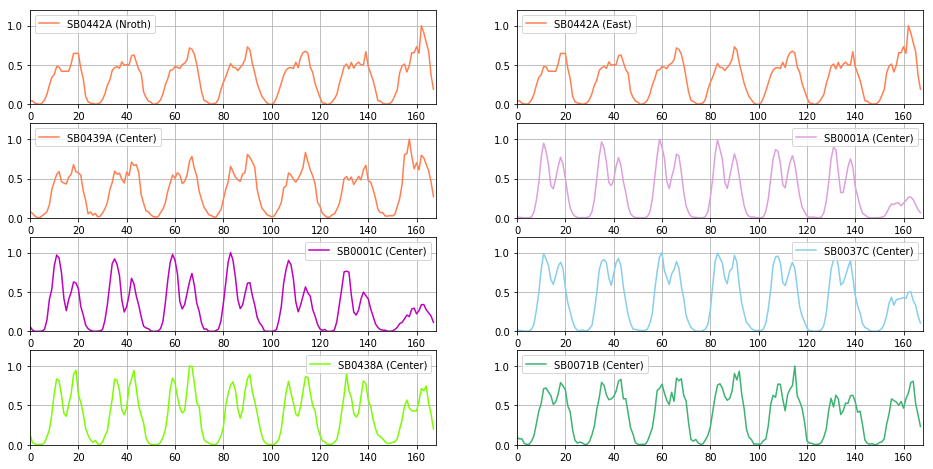

In [40]:
'''
clr = ['lawngreen','coral','plum','skyblue','y','m','mediumseagreen','red']
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
ind = np.where(np.array(sector) =='SB0167A')[0][0]
ind2 = np.where(np.array(sector) =='SB0442A')[0][0]
ind3 = np.where(np.array(sector) =='SB0439A')[0][0]
ind4 = np.where(np.array(sector) =='SB0001A')[0][0]

plt.plot(x[ind,:], label='TH1584A', color = 'skyblue')
plt.plot(x[ind2,:], label='TH1584B', color = 'mediumseagreen')
plt.plot(x[ind3,:], label='TH1584C', color = 'm')
plt.plot(x[ind4,:], label='TH1584D', color = 'r')
plt.legend()
'''
fig, ax = plt.subplots(4, 2)
fig.set_figheight(8)
fig.set_figwidth(16)

cell_list = ['SB0442A','SB0442A','SB0439A','SB0001A','SB0001C','SB0037C','SB0438A','SB0071B']
cc = 0
#clr = ['lawngreen','coral','plum','skyblue','y','m','mediumseagreen','red']
clr = ['coral','coral','coral','plum','m','skyblue','lawngreen','mediumseagreen']
lbl = ['SB0442A (Nroth)','SB0442A (East)','SB0439A (Center)','SB0001A (Center)',\
      'SB0001C (Center)','SB0037C (Center)','SB0438A (Center)','SB0071B (Center)']
for row in ax:
    for col in row:
        ind = np.where(np.array(sector) ==cell_list[cc])[0][0]
        col.plot(x[ind,:], label=lbl[cc], color = clr[cc])
        #col.set_ylim((0.1,0.9)), col.set_xlim((0,20))
        col.set_ylim((0.0,1.2)), col.set_xlim((0,168))
        col.legend()
        col.grid()
        cc += 1

plt.show()

IndexError: list index out of range

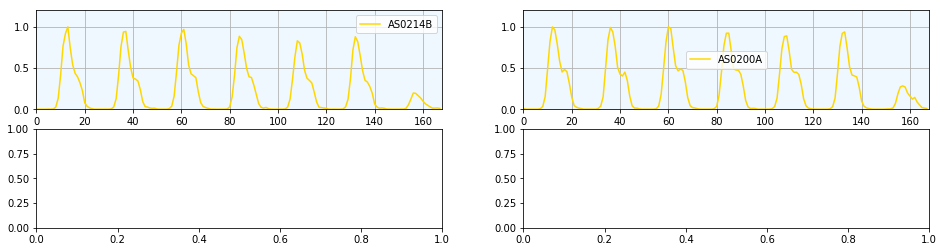

In [25]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4)
fig.set_figwidth(16)

#cell_list = ['MA0541A','TH0229C','TH1419A','KJ0016B','SK0125A','KH0305C','KH1091A','NK0074C']#'NK0056C']

#cell_list = ['YZ0137A','YZ0581A','YZ0197A','YZ0284A','YZ0027A']
cell_list = ['AS0214B','AS0200A']
cc = 0
#clr = ['lawngreen','coral','plum','skyblue','y','m','mediumseagreen','red']
clr = ['maroon','maroon','coral','coral','coral','coral','coral','coral']
lbl = cell_list#['Highway (Chamran-Niayesh)','Residential (Sabalan St.)','KJ0016B','SK0125A','Ghochan','KH1091A','NK0074C','NK0056C']
for row in ax:
    for col in row:
        ind = np.where(np.array(sector) ==cell_list[cc])[0][0]
        col.set_facecolor('aliceblue')
        col.plot(x[ind,:], label=lbl[cc], color = 'gold')#clr[cc])
        #col.set_ylim((0.1,0.9)), col.set_xlim((0,20))
        col.set_ylim((0.0,1.2)), col.set_xlim((0,168))
        col.legend()
        col.grid()
        cc += 1

plt.show()

In [155]:
fn_2g = "3G-2.csv"
testpd = pd.read_csv(fn_2g)
len(testpd['CellName'].unique())


138162

In [27]:
df0 = df.copy()
df0['Province'] = df0['Sector'].str[:2]
ind_provence = pd.read_excel('.//maps//Index_Province.xlsx')
ind_provence.head()
df0 = df0.merge(ind_provence[['INdex','Province']], left_on = ['Province'], right_on = ['INdex'])
df0.head()

Index(['Date', 'AVL_x', 'Sector', 'AVL_y', 'TCHTRF', 'Gen', 'Prov'], dtype='object')

In [71]:
len(Main_Input_Network)/168

60230.07142857143

In [61]:
np.shape(X)[0]/168

39861.0

In [28]:
df0 = df.copy()
df0['Province'] = df0['Sector'].str[:2]
ind_provence = pd.read_excel('.//maps//Index_Province.xlsx')
ind_provence.head()
df0 = df0.merge(ind_provence[['INdex','Province']], left_on = ['Province'], right_on = ['INdex'])

traffic_flag = False

df0 = df0.rename(columns={'Province_y': 'Province'})
if traffic_flag:
    df2 = df0.groupby(['Province','Labels'],as_index = False)['Total'].mean()
else:
    df2 = df0.groupby(['Province','Labels'],as_index = False).count()
    
df2 = df2.set_index(['Labels','Province']).unstack(level=0)
#clr_lbl = ['Event','Comm. HOP','Resi. LOP','Admin','Evening','Bazzar','Resi. HOP','Comm. LOP']
df2 = df2.rename(columns={0: 'Event',1: 'Comm. HOP',2: 'Resi. LOP',3: 'Admin', \
                          4: 'Resi. HE',5: 'Bazzar',6: 'Resi. HOP',7: 'Comm. LOP'}) 



if traffic_flag:
    df2 = df2['Total']
else:
    df2 = df2['Sector']
    
df2 = df2[df2.index != 'XH']
if not traffic_flag:
    df2['sum'] = df2.sum(axis =1)
    df_new = df2.div(df2['sum'], axis = 0)*100.0
    df_new.drop('sum',axis = 1,inplace = True)
else:
    df_new = df2.copy()
    
writer = ExcelWriter('ProvinceLevel.xlsx')
df_new.to_excel(writer)
writer.save()

In [29]:
province_captials = ['Ahvaz', 'Arak', 'Ardebil', 'Bandar abbas',
       'Birjand', 'Bojnurd', 'Bushehr', 'Esfehan',
        'Gorgan', 'Hamedan', 'Ilam','Karaj', 'Kerman', 'Kermanshah', 
       'Khoram abad', 'Mashhad', 'Oroumieh','Qazvin','Qom','Rasht', 'Sanandaj',
       'Sari', 'Semnan', 'Shahrekord','Shiraz','Tabriz', 'Yasouj', 'Yazd', 'Zahedan', 'Zanjan', 'Tehran']
df_city = df0.copy()
df_city['Site'] = df_city['Sector'].str[:-1]
print('CAAUTION you are running this code for the second time!')
#df_city.drop(['Province_x','INdex'], axis = 1, inplace = True)
              
mci_cities = pd.read_excel('.//maps//MCI_City_File.xlsx')
df_city = df_city.merge(mci_cities[['Site','City']], left_on = ['Site'], right_on = ['Site'])

traffic_flag = False
if traffic_flag:
    df2_c = df_city.groupby(['City','Labels'],as_index = False)['Total'].mean()
else:
    df2_c = df_city.groupby(['City','Labels'],as_index = False).count()
    
    
#df2_c = df_city.groupby(['City','Labels'],as_index = False).count()
df2_c = df2_c.set_index(['Labels','City']).unstack(level=0)

df2_c = df2_c.rename(columns={0: 'Event',1: 'Comm. HOP',2: 'Resi. LOP',3: 'Admin', \
                          4: 'Resi. HE',5: 'Bazzar',6: 'Resi. HOP',7: 'Comm. LOP'}) 
if traffic_flag:
    df2_c = df2_c['Total']
else:
    df2_c = df2_c['Site']
df2_c.fillna(0, inplace=True)
df2_c['sum'] = df2_c.sum(axis =1)

s = df2_c.xs('Abad') # random name : it is changed 
if traffic_flag:
    s = df2_c[df2_c.index.str[:6]=='Tehran'].mean(axis=0);
else:
    s = df2_c[df2_c.index.str[:6]=='Tehran'].sum(axis=0);
s.name = 'Tehran'
df2_c = df2_c.append(s)
df2_c = df2_c[df2_c.index.str[:7]!='Tehran_']
# To excel
df2_c_all = df2_c.copy()
writer = ExcelWriter('cities_cluster_sum_traffic.xlsx')
df2_c_all.to_excel(writer)
writer.save()

df2_c = df2_c.reindex(province_captials)
if not traffic_flag:
    df2_c_new = df2_c.div(df2_c['sum'], axis = 0)*100.0
    df2_c_new.drop('sum',axis = 1,inplace = True)
else:
    df2_c_new = df2_c.copy()
    
writer = ExcelWriter('CityLevel.xlsx')
df2_c_new.to_excel(writer)
writer.save()

CAAUTION you are running this code for the second time!


In [32]:
traffic_flag = False

df0 = df0.rename(columns={'Province_y': 'Province'})
if traffic_flag:
    df2 = df0.groupby(['Province','Labels'],as_index = False)['Total'].mean()
else:
    df2 = df0.groupby(['Province','Labels'],as_index = False).count()
    
df2 = df2.set_index(['Labels','Province']).unstack(level=0)
#clr_lbl = ['Event','Comm. HOP','Resi. LOP','Admin','Evening','Bazzar','Resi. HOP','Comm. LOP']
df2 = df2.rename(columns={0: 'Event',1: 'Comm. HOP',2: 'Resi. LOP',3: 'Admin', \
                          4: 'Resi. HE',5: 'Bazzar',6: 'Resi. HOP',7: 'Comm. LOP'}) 
if traffic_flag:
    df2 = df2['Total']
else:
    df2 = df2['Sector']
    
df2 = df2[df2.index != 'XH']
if not traffic_flag:
    df2['sum'] = df2.sum(axis =1)
    df_new = df2.div(df2['sum'], axis = 0)*100.0
    df_new.drop('sum',axis = 1,inplace = True)
else:
    df_new = df2.copy()
#df_new = df2.copy()

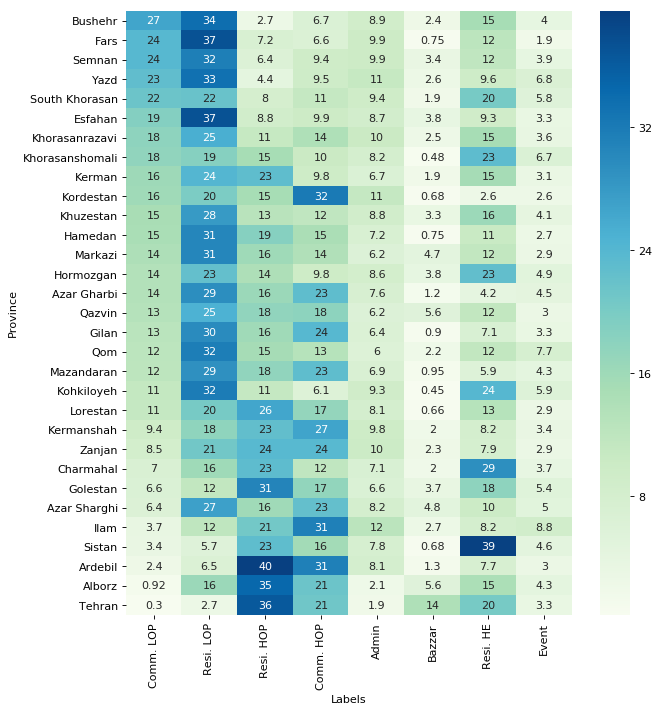

In [33]:
import seaborn as sns
%matplotlib inline
#clr_lbl = ['Event','Comm. HOP','Resi. LOP','Admin','Evening','Bazzar','Resi. HOP','Comm. LOP']
plt.figure(num=None, figsize=(9, 10), dpi=80, facecolor='w', edgecolor='k')
if traffic_flag:
    df_new = df_new.sort_values(by = ['Comm. LOP','Resi. LOP','Resi. HOP'], ascending=False)
    df_new = df_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df_new/1e3, annot=True, cmap = 'GnBu')
else:
    df_new = df_new.sort_values(by = ['Comm. LOP','Resi. LOP','Resi. HOP'], ascending=False)
    df_new = df_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df_new, annot=True, cmap = 'GnBu')
    
plt.show()

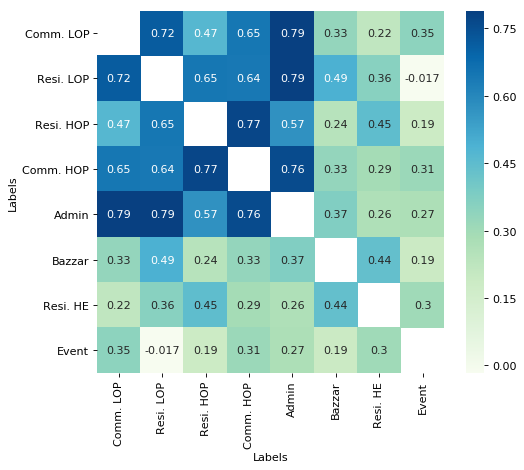

In [23]:
dfcorr = df_new.corr()

np.fill_diagonal(dfcorr.values, 0)
mask = np.zeros_like(dfcorr)
mask[np.diag_indices_from(mask)] = True

plt.figure(num=None, figsize=(7, 6), dpi=80, facecolor='w', edgecolor='k')
#df_new = df_new.sort_values(by = [7], ascending=False)
sns.set_palette('RdBu_r')
sns.heatmap(dfcorr, annot = True, mask = mask, cmap = 'GnBu')
plt.show()

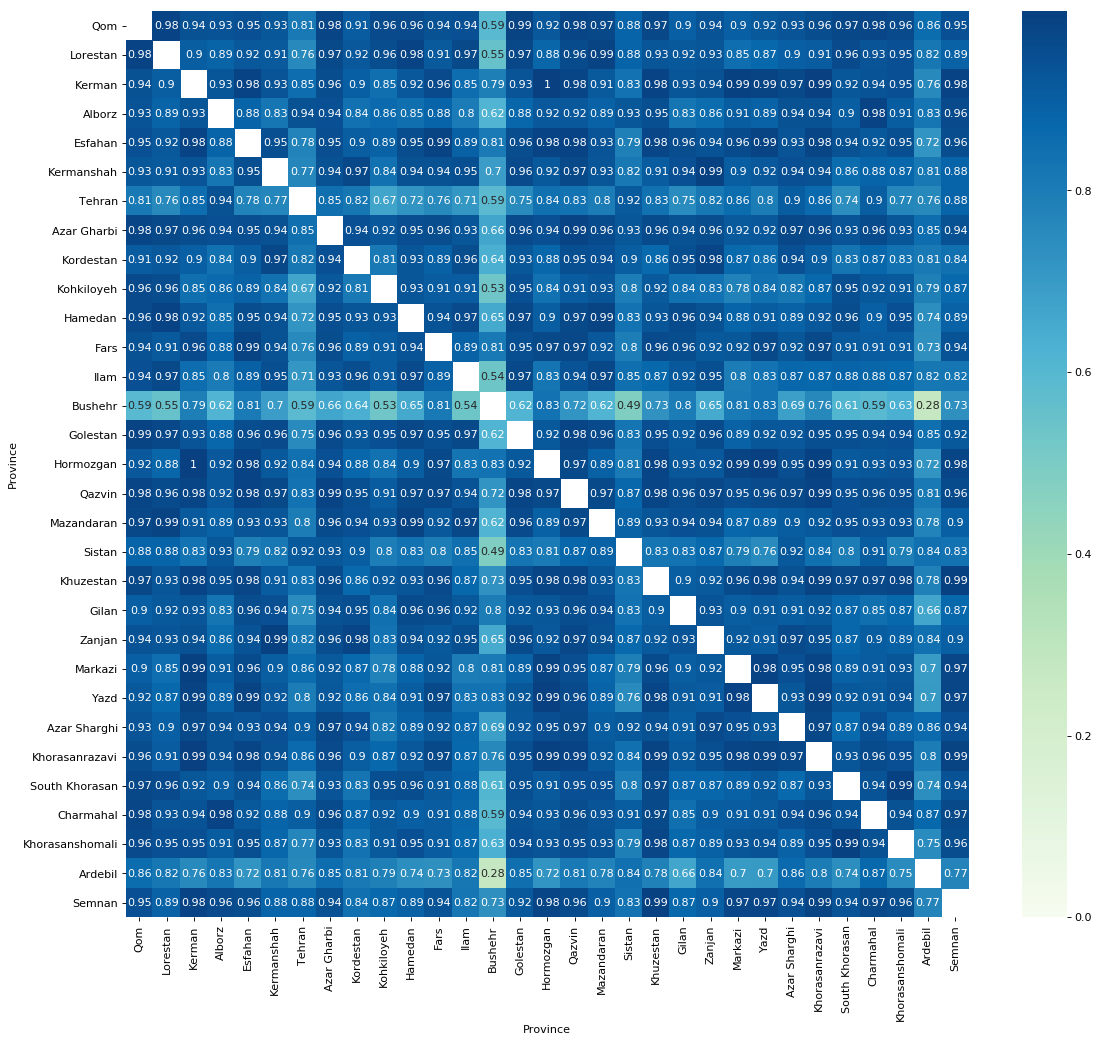

In [56]:
dfcorr_P = df_new.T.corr(method = 'pearson')

np.fill_diagonal(dfcorr_P.values, 0)
mask = np.zeros_like(dfcorr_P)
mask[np.diag_indices_from(mask)] = True

plt.figure(num=None, figsize=(17, 15), dpi=80, facecolor='w', edgecolor='k')
#df_new = df_new.sort_values(by = [7], ascending=False)
sns.set_palette('RdBu_r')
sns.heatmap(dfcorr_P, annot=True, mask = mask, cmap = 'GnBu')
plt.show()

In [34]:
province_captials = ['Ahvaz', 'Arak', 'Ardebil', 'Bandar abbas',
       'Birjand', 'Bojnurd', 'Bushehr', 'Esfehan',
        'Gorgan', 'Hamedan', 'Ilam','Karaj', 'Kerman', 'Kermanshah', 
       'Khoram abad', 'Mashhad', 'Oroumieh','Qazvin','Qom','Rasht', 'Sanandaj',
       'Sari', 'Semnan', 'Shahrekord','Shiraz','Tabriz', 'Yasouj', 'Yazd', 'Zahedan', 'Zanjan', 'Tehran']
df_city = df0.copy()
df_city['Site'] = df_city['Sector'].str[:-1]
print('CAAUTION you are running this code for the second time!')
#df_city.drop(['Province_x','INdex'], axis = 1, inplace = True)
              
mci_cities = pd.read_excel('.//maps//MCI_City_File.xlsx')
df_city = df_city.merge(mci_cities[['Site','City']], left_on = ['Site'], right_on = ['Site'])
df_city.head()

CAAUTION you are running this code for the second time!


,Sector,Labels,Total,Province_x,INdex,Province,Site,City
0,AG0001A,1,2567.056,AG,AG,Azar Gharbi,AG0001,Oroumieh
1,AG0001B,1,4003.468,AG,AG,Azar Gharbi,AG0001,Oroumieh
2,AG0001C,6,5908.020,AG,AG,Azar Gharbi,AG0001,Oroumieh
3,AG0002A,1,3903.194,AG,AG,Azar Gharbi,AG0002,Oroumieh
4,AG0002B,3,7039.394,AG,AG,Azar Gharbi,AG0002,Oroumieh


In [35]:
print('CAAUTION you are running this code for the second time!')
#df_city.drop(['Province','Sector'], axis = 1, inplace = True)
traffic_flag = False
if traffic_flag:
    df2_c = df_city.groupby(['City','Labels'],as_index = False)['Total'].mean()
else:
    df2_c = df_city.groupby(['City','Labels'],as_index = False).count()
    
    
#df2_c = df_city.groupby(['City','Labels'],as_index = False).count()
df2_c = df2_c.set_index(['Labels','City']).unstack(level=0)

df2_c = df2_c.rename(columns={0: 'Event',1: 'Comm. HOP',2: 'Resi. LOP',3: 'Admin', \
                          4: 'Resi. HE',5: 'Bazzar',6: 'Resi. HOP',7: 'Comm. LOP'}) 
if traffic_flag:
    df2_c = df2_c['Total']
else:
    df2_c = df2_c['Site']
df2_c.fillna(0, inplace=True)
df2_c['sum'] = df2_c.sum(axis =1)

s = df2_c.xs('Abad') # random name : it is changed 
if traffic_flag:
    s = df2_c[df2_c.index.str[:6]=='Tehran'].mean(axis=0);
else:
    s = df2_c[df2_c.index.str[:6]=='Tehran'].sum(axis=0);
s.name = 'Tehran'
df2_c = df2_c.append(s)
df2_c = df2_c[df2_c.index.str[:7]!='Tehran_']
# To excel
df2_c_all = df2_c.copy()
writer = ExcelWriter('cities_cluster_sum_traffic.xlsx')
df2_c_all.to_excel(writer)
writer.save()

df2_c = df2_c.reindex(province_captials)
if not traffic_flag:
    df2_c_new = df2_c.div(df2_c['sum'], axis = 0)*100.0
    df2_c_new.drop('sum',axis = 1,inplace = True)
else:
    df2_c_new = df2_c.copy()
#plt.plot(df2_c['sum'].sort_values().values)

CAAUTION you are running this code for the second time!


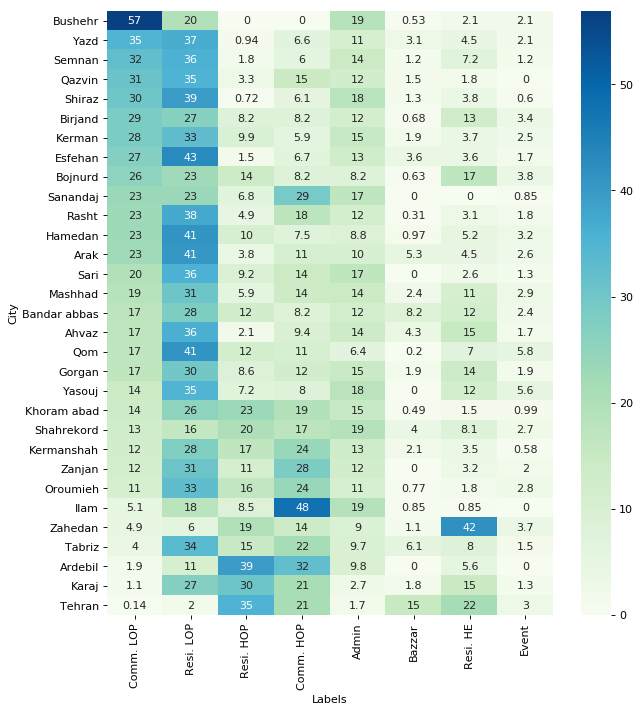

In [36]:
import seaborn as sns
%matplotlib inline

plt.figure(num=None, figsize=(9, 10), dpi=80, facecolor='w', edgecolor='k')
if traffic_flag:
    df2_c_new = df2_c_new.sort_values(by = ['Comm. LOP','Resi. LOP','Resi. HOP'], ascending=False)
    df2_c_new = df2_c_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df2_c_new/1e3, annot=True, cmap = 'GnBu')
else:
    df2_c_new = df2_c_new.sort_values(by = ['Comm. LOP','Resi. LOP','Resi. HOP'], ascending=False)
    df2_c_new = df2_c_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df2_c_new, annot=True, cmap = 'GnBu')
plt.show()

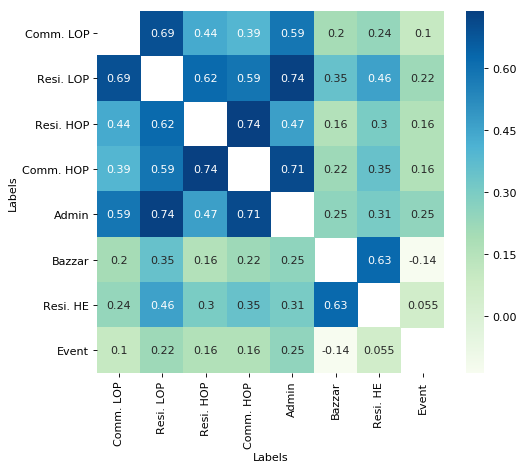

In [33]:
dfcorr = df2_c_new.corr()

np.fill_diagonal(dfcorr.values, 0)
mask = np.zeros_like(dfcorr)
mask[np.diag_indices_from(mask)] = True

plt.figure(num=None, figsize=(7, 6), dpi=80, facecolor='w', edgecolor='k')
#df_new = df_new.sort_values(by = [7], ascending=False)
sns.set_palette('RdBu_r')
sns.heatmap(dfcorr, annot=True, mask = mask, cmap = 'GnBu')
plt.show()

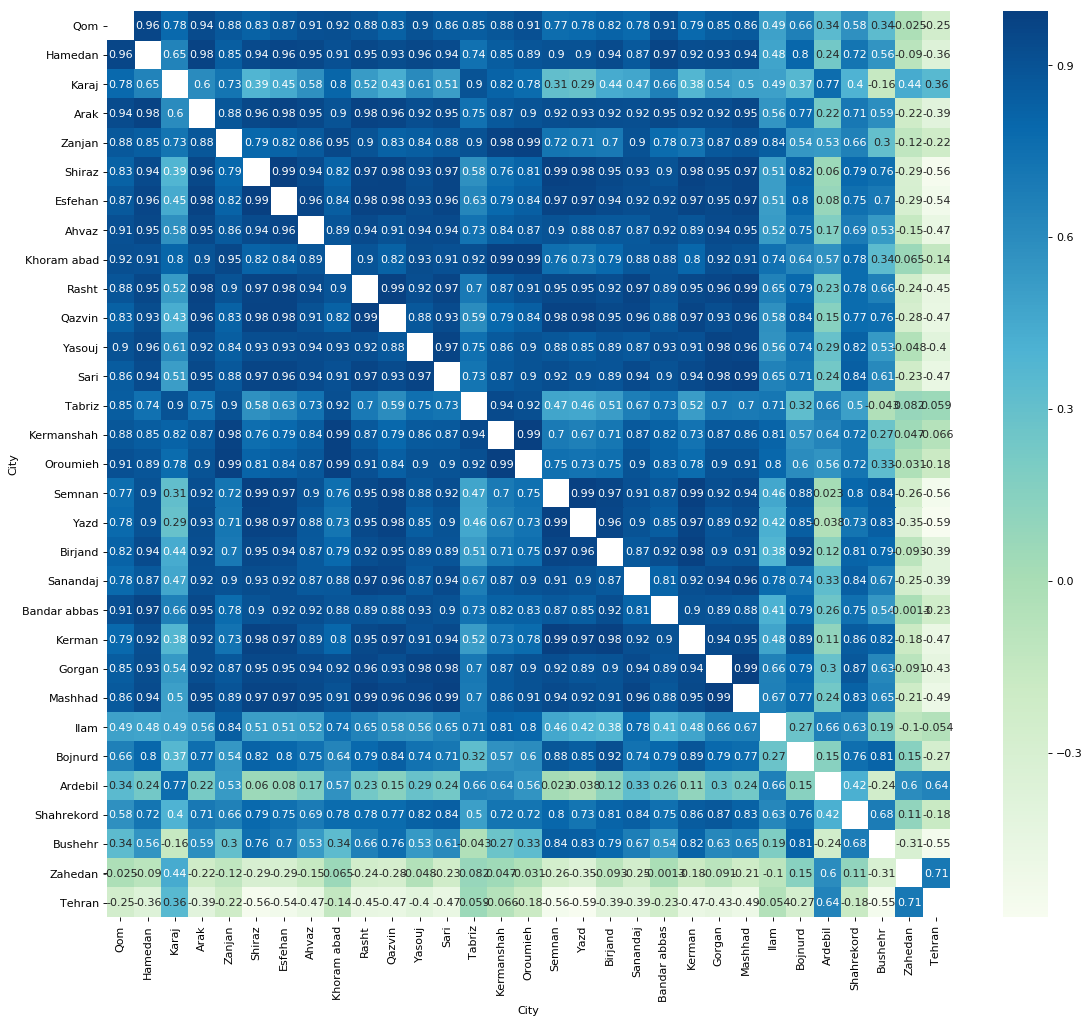

In [16]:
dfcorr_P = df2_c_new.T.corr(method = 'pearson')

np.fill_diagonal(dfcorr_P.values, 0)
mask = np.zeros_like(dfcorr_P)
mask[np.diag_indices_from(mask)] = True

plt.figure(num=None, figsize=(17, 15), dpi=80, facecolor='w', edgecolor='k')
#df_new = df_new.sort_values(by = [7], ascending=False)
sns.set_palette('RdBu_r')
sns.heatmap(dfcorr_P, annot=True, mask = mask, cmap = 'GnBu')
plt.show()

In [30]:
df2_c

NameError: name 'df2_c' is not defined

In [42]:
df.head()

,Sector,Labels,Total
0,AG0001A,0,2567.056
1,AG0001B,0,4003.468
2,AG0001C,0,5908.020
3,AG0002A,0,3903.194
4,AG0002B,4,7039.394


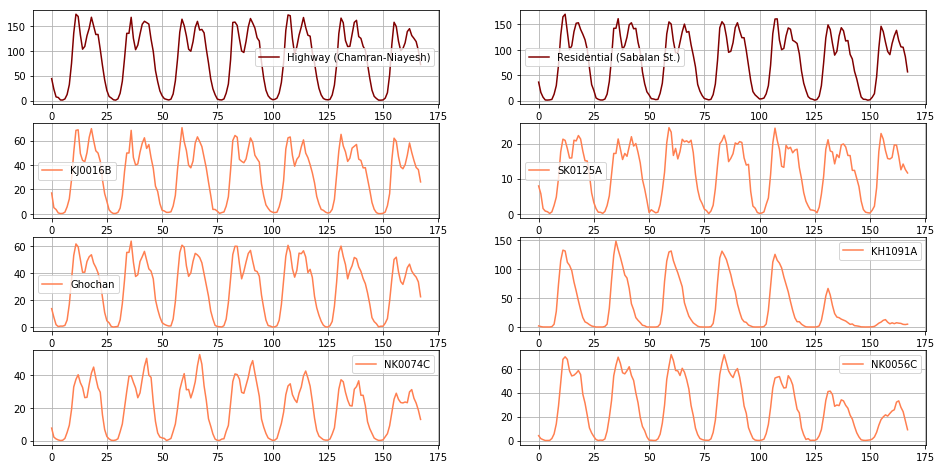

In [97]:
fig, ax = plt.subplots(4, 2)
fig.set_figheight(8)
fig.set_figwidth(16)

cell_list = ['KD0349A','KD0349B','KD0528A','KD0528C','KD0380B','TH1467A','TH0068A','TH0430C']
cc = 0
#clr = ['lawngreen','coral','plum','skyblue','y','m','mediumseagreen','red']
clr = ['maroon','maroon','coral','coral','coral','coral','coral','coral']
lbl = ['Highway (Chamran-Niayesh)','Residential (Sabalan St.)','KJ0016B','SK0125A','Ghochan','KH1091A','NK0074C','NK0056C']
for row in ax:
    for col in row:
        ind = np.where(np.array(sector) ==cell_list[cc])[0][0]
        col.plot(xo[ind,:], label=lbl[cc], color = clr[cc])
        #col.set_ylim((0.1,0.9)), col.set_xlim((0,20))
        #col.set_ylim((0.0,1.2)), col.set_xlim((0,168))
        col.legend()
        col.grid()
        cc += 1

plt.show()

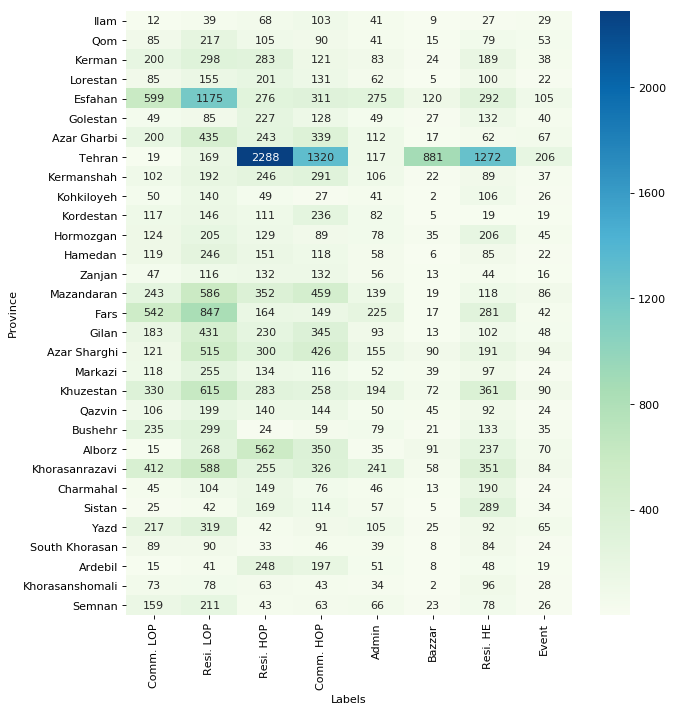

In [72]:
traffic_flag = False

#df = df.rename(columns={'Province_y': 'Province'})
if traffic_flag:
    df2 = df0.groupby(['Province','Labels'],as_index = False)['Total'].mean()
else:
    df2 = df0.groupby(['Province','Labels'],as_index = False).count()
    
df2 = df2.set_index(['Labels','Province']).unstack(level=0)

df2 = df2.rename(columns={0: 'Event',1: 'Comm. HOP',2: 'Resi. LOP',3: 'Admin', \
                          4: 'Resi. HE',5: 'Bazzar',6: 'Resi. HOP',7: 'Comm. LOP'}) 
if traffic_flag:
    df2 = df2['Total']
else:
    df2 = df2['Sector']
    
df2 = df2[df2.index != 'XH']
if not traffic_flag:
    df2['sum'] = df2.sum(axis =1)
    df_new = df2.div(df2['sum'], axis = 0)*100.0
    df_new.drop('sum',axis = 1,inplace = True)
else:
    df_new = df2.copy()
df_new = df2.copy()

import seaborn as sns
%matplotlib inline

plt.figure(num=None, figsize=(9, 10), dpi=80, facecolor='w', edgecolor='k')
if traffic_flag:
    #df2_c_new = df2_c_new.sort_values(by = ['pink','lightgreen','green'], ascending=False)
    df2_new = df_new.reindex(sort_index)
    df2_new = df2_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df2_new/1e3, annot=True, cmap = 'GnBu')
else:
    #df2_new = df2_new.sort_values(by = ['pink','lightgreen','green'], ascending=False)
    df2_new = df2_new.reindex(sort_index)
    df2_new = df2_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df2_new, annot=True, cmap = 'GnBu',  fmt = 'g')
plt.show()

In [56]:
sort_index

Index(['Alborz', 'Ardebil', 'Azar Gharbi', 'Azar Sharghi', 'Bushehr',
       'Charmahal', 'Esfahan', 'Fars', 'Gilan', 'Golestan', 'Hamedan',
       'Hormozgan', 'Ilam', 'Kerman', 'Kermanshah', 'Khorasanrazavi',
       'Khorasanshomali', 'Khuzestan', 'Kohkiloyeh', 'Kordestan', 'Lorestan',
       'Markazi', 'Mazandaran', 'Qazvin', 'Qom', 'Semnan', 'Sistan',
       'South Khorasan', 'Tehran', 'Yazd', 'Zanjan'],
      dtype='object', name='Province')

In [100]:
df2_c_new.head()

Labels,lightblue,red,yellow,orange,purple,pink,lightgreen,green,sum
City,,,,,,,,,
Ahvaz,43.0,4.0,27.0,67.0,97.0,138.0,249.0,29.0,654.0
Arak,26.0,6.0,13.0,6.0,30.0,75.0,117.0,13.0,286.0
Ardebil,95.0,0.0,2.0,10.0,38.0,11.0,65.0,83.0,304.0
Bandar abbas,19.0,6.0,29.0,17.0,43.0,75.0,117.0,47.0,353.0
Birjand,5.0,4.0,2.0,3.0,18.0,50.0,49.0,16.0,147.0


In [117]:
sort_ind = df2_c_new.index

In [59]:
df_new

Labels,lightblue,red,yellow,orange,purple,pink,lightgreen,green,sum
Province,,,,,,,,,
Alborz,70,350,268,35,237,91,562,15,1628
Ardebil,19,197,41,51,48,8,248,15,627
Azar Gharbi,67,339,435,112,62,17,243,200,1475
Azar Sharghi,94,426,515,155,191,90,300,121,1892
Bushehr,35,59,299,79,133,21,24,235,885
Charmahal,24,76,104,46,190,13,149,45,647
Esfahan,105,311,1175,275,292,120,276,599,3153
Fars,42,149,847,225,281,17,164,542,2267
Gilan,48,345,431,93,102,13,230,183,1445


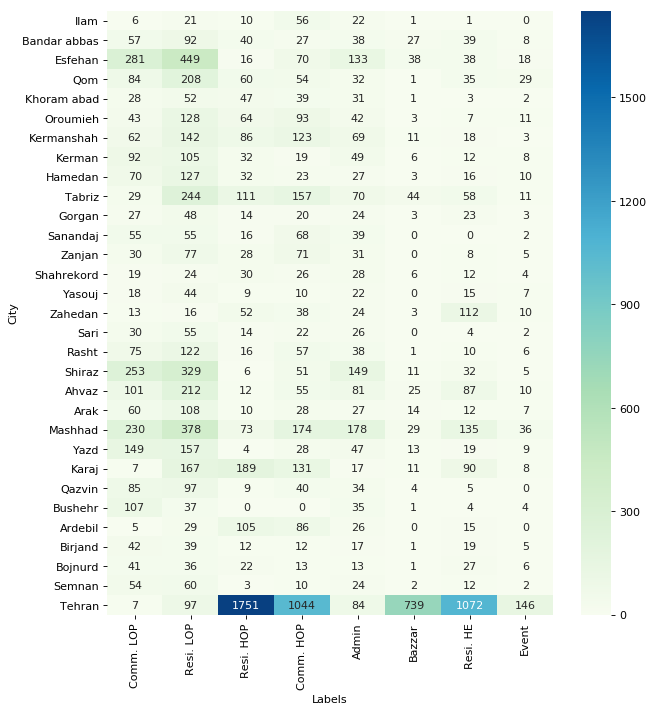

In [62]:
plt.figure(num=None, figsize=(9, 10), dpi=80, facecolor='w', edgecolor='k')
traffic_flag = False
if traffic_flag:
    #df2_c_new = df2_c_new.sort_values(by = ['pink','lightgreen','green'], ascending=False)
    df3_new = df_new.reindex(sort_ind)
    df3_new = df3_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df3_new/1e3, annot=True, cmap = 'GnBu')
else:
    #df2_new = df2_new.sort_values(by = ['pink','lightgreen','green'], ascending=False)
    df3_new = df_new.reindex(sort_ind)
    df3_new = df3_new[['Comm. LOP','Resi. LOP','Resi. HOP','Comm. HOP','Admin','Bazzar','Resi. HE','Event']]
    sns.heatmap(df3_new, annot=True, cmap = 'GnBu',  fmt='g')
plt.show()

In [58]:
sort_ind

Index(['Ilam', 'Bandar abbas', 'Esfehan', 'Qom', 'Khoram abad', 'Oroumieh',
       'Kermanshah', 'Kerman', 'Hamedan', 'Tabriz', 'Gorgan', 'Sanandaj',
       'Zanjan', 'Shahrekord', 'Yasouj', 'Zahedan', 'Sari', 'Rasht', 'Shiraz',
       'Ahvaz', 'Arak', 'Mashhad', 'Yazd', 'Karaj', 'Qazvin', 'Bushehr',
       'Ardebil', 'Birjand', 'Bojnurd', 'Semnan', 'Tehran'],
      dtype='object', name='City')

In [71]:
sort_index = df_new.index

In [52]:
sort_ind = df2_c_new.index

In [61]:
df_new =df2_c.copy()

In [70]:
df_new.index

Index(['Ilam', 'Qom', 'Kerman', 'Lorestan', 'Esfahan', 'Golestan',
       'Azar Gharbi', 'Tehran', 'Kermanshah', 'Kohkiloyeh', 'Kordestan',
       'Hormozgan', 'Hamedan', 'Zanjan', 'Mazandaran', 'Fars', 'Gilan',
       'Azar Sharghi', 'Markazi', 'Khuzestan', 'Qazvin', 'Bushehr', 'Alborz',
       'Khorasanrazavi', 'Charmahal', 'Sistan', 'Yazd', 'South Khorasan',
       'Ardebil', 'Khorasanshomali', 'Semnan'],
      dtype='object', name='Province')

In [30]:
6698+4736

11434

In [31]:
9106+7700+5542

22348